In [ ]:
import os
import shutil
import keras
import tensorflow as tf
import numpy as np

In [ ]:
from urllib.request import urlretrieve

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


In [ ]:
BATCH_SIZE = 64
SEED = 42
MAX_SEQUENCE_LENGTH = 512
VOCAB_SIZE = 10000
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
_DOWNLOAD_URL = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = _DOWNLOAD_URL.split("/")[-1]

print(filename)

aclImdb_v1.tar.gz


In [ ]:
def download_dataset(url, filename):
  path, headers = urlretrieve(url, filename)
  print(f"File Downloaded successfully: {path}")
  print()
  print(headers)

def uncompress_dataset(filepath, extract_dir=None):
  if extract_dir is None:
    extract_dir = os.getcwd()
  shutil.unpack_archive(filepath, extract_dir)
  print(f"File extracted successfully to {extract_dir}")
  print(f"Contents of the directory:")
  print(os.listdir(extract_dir))
  return extract_dir

In [ ]:
download_dataset(_DOWNLOAD_URL, filename)
dataset_dir = uncompress_dataset(filename)

File Downloaded successfully: aclImdb_v1.tar.gz

Date: Tue, 16 Apr 2024 06:57:53 GMT
Server: Apache/2.2.15 (CentOS)
Last-Modified: Sun, 26 Jun 2011 01:16:03 GMT
ETag: "6d4b0748-503a881-4a6932da47ac0"
Accept-Ranges: bytes
Content-Length: 84125825
Connection: close
Content-Type: application/x-gzip


File extracted successfully to /content
Contents of the directory:
['.config', 'aclImdb_v1.tar.gz', 'aclImdb', 'sample_data']


In [ ]:
dataset_path = os.path.join(dataset_dir, 'aclImdb')

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

print(f"Training directory:{os.listdir(train_dir)}")
print(f"Test directory:{os.listdir(test_dir)}")

Training directory:['urls_pos.txt', 'urls_unsup.txt', 'neg', 'unsup', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'pos']
Test directory:['urls_pos.txt', 'neg', 'labeledBow.feat', 'urls_neg.txt', 'pos']


In [ ]:
rmdir = os.path.join(train_dir, 'unsup')
shutil.rmtree(rmdir)

In [ ]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=SEED,
                                                          validation_split=0.2,
                                                          subset='training')
raw_val_ds = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=True,
                                                        seed=SEED,
                                                        validation_split=0.2,
                                                        subset='validation')
raw_test_ds = tf.keras.utils.text_dataset_from_directory(test_dir,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(2):
    print(f"Review:{text_batch[i]}")
    print(f"Label:{label_batch[i]}")

Review:b"First of all, I liked very much the central idea of locating the '' intruders'', Others in the fragile Self, on various levels - mainly subconscious but sometimes more allegorical. In fact the intruders are omnipresent throughout the film : in the Swiss-French border where the pretagonist leads secluded life; in the his recurring daydream and nightmare; inside his ailing body after heart transplantation.... In the last half of the film, he becomes intruder himself, returning in ancient french colony in the hope of atoning for the past. <br /><br />The overall tone is bitter rather than pathetic, full of regrets and guilts, sense of failure being more or less dominant. This is a quite grim picture of an old age, ostensibly self-dependent but hopelessly void and lonely inside. The directer composes the images more to convey passing sensations of anxiety and desire than any explicit meanings. Some of them are mesmerizing, not devoid of humor though, kind of absurdist play only so

Vectorization using two techniques:
1. Bag of words of binary vectorization - returns multi-hot encoded vector
2. Int output - converts strings to numerical index representing vocab word index


In [ ]:
text, label = next(iter(raw_train_ds.take(1)))


In [ ]:
text, label

(<tf.Tensor: shape=(64,), dtype=string, numpy=
 array([b'Every scene was put together perfectly.This movie had a wonderful cast and crew. I mean, how can you have a bad movie with Robert Downey Jr. in it,none have and ever will exist. He has the ability to brighten up any movie with his amazing talent.This movie was perfect! I saw this movie sitting all alone on a movie shelf in "Blockbuster" and like it was calling out to me,I couldn\'t resist picking it up and bringing it home with me. You can call me a sappy romantic, but this movie just touched my heart, not to mention made me laugh with pleasure at the same time. Even though it made me cry,I admit, at the end, the whole movie just brightened up my outlook on life thereafter.I suggested to my horror, action, and pure humor movie buff of a brother,who absolutely adored this movie. This is a movie with a good sense of feeling.It could make you laugh out loud, touch your heart, make you fall in love,and enjoy your life.Every time you 

In [ ]:
int_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

binary_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    output_mode='binary'
)

In [ ]:
train_text = raw_train_ds.map(lambda text, label: text)
int_vectorization.adapt(train_text)
binary_vectorization.adapt(train_text)

In [ ]:
text_sample = next(iter(train_text))[5]
int_output = int_vectorization(text_sample)
binary_output = binary_vectorization(text_sample)

In [ ]:
print(f"Sample Review:{text_sample}")
print(int_output)

Sample Review:b'Ronald Colman plays a famous Broadway actor who has begun to lose his mind and sense of identity. After years of playing a wide range of parts, he can\'t remember who he exactly is--who are his roles and who is the self. And, much more serious, he begins to see and hear his play even in regular everyday life. So, since he\'s currently playing in "Othello", he begins to act jealous and suspicious--just like the title character. Ultimately, it leads him to the depths of insanity and murder.<br /><br />I saw this film years ago and liked it. I just saw it again and loved it. Now perhaps some of my enthusiasm is because I have always liked Ronald Colman and this is a great triumph for him--and for which he earned the Best Actor Oscar. And, looking at the competition that year (Gregory Peck for GENTLEMAN\'S AGREEMENT, John Garfield for BODY AND SOUL, William Powell for LIFE WITH FATHER and Michael Redgrave for MOURNING BECOMES ELECTRA), I think Colman was a very good choice,

In [ ]:
print(f"Sample Review:{text_sample}")
print(binary_output)

Sample Review:b'Ronald Colman plays a famous Broadway actor who has begun to lose his mind and sense of identity. After years of playing a wide range of parts, he can\'t remember who he exactly is--who are his roles and who is the self. And, much more serious, he begins to see and hear his play even in regular everyday life. So, since he\'s currently playing in "Othello", he begins to act jealous and suspicious--just like the title character. Ultimately, it leads him to the depths of insanity and murder.<br /><br />I saw this film years ago and liked it. I just saw it again and loved it. Now perhaps some of my enthusiasm is because I have always liked Ronald Colman and this is a great triumph for him--and for which he earned the Best Actor Oscar. And, looking at the competition that year (Gregory Peck for GENTLEMAN\'S AGREEMENT, John Garfield for BODY AND SOUL, William Powell for LIFE WITH FATHER and Michael Redgrave for MOURNING BECOMES ELECTRA), I think Colman was a very good choice,

(0.0, 10000.0)

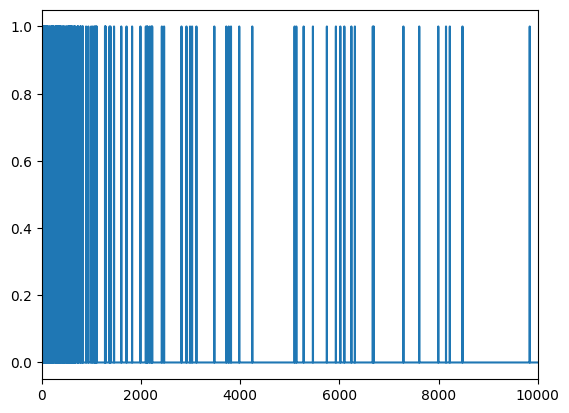

In [ ]:
import matplotlib.pyplot as plt

plt.plot(binary_output.numpy())
plt.xlim(0,VOCAB_SIZE)

In [ ]:
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.prefetch(buffer_size=AUTOTUNE)

## Model

In [ ]:
int_rnn_model = keras.models.Sequential()
#int_rnn_model.add(keras.layers.Input(shape=(None,)))
int_rnn_model.add(int_vectorization)
int_rnn_model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64))
int_rnn_model.add(keras.layers.SimpleRNN(128))
int_rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

int_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 664833 (2.54 MB)
Trainable params: 664833 (2.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
int_rnn_model.compile(loss=keras.losses.BinaryCrossentropy(),
                      optimizer=keras.optimizers.RMSprop(),
                      metrics=['accuracy'])
int_rnn_model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=10)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 233ms/step - accuracy: 0.5009 - loss: 0.7060 - val_accuracy: 0.5076 - val_loss: 0.6953
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 226ms/step - accuracy: 0.4974 - loss: 0.6963 - val_accuracy: 0.5076 - val_loss: 0.6950
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - accuracy: 0.4997 - loss: 0.6961 - val_accuracy: 0.5076 - val_loss: 0.6949
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 225ms/step - accuracy: 0.4993 - loss: 0.6960 - val_accuracy: 0.5076 - val_loss: 0.6947
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 226ms/step - accuracy: 0.4991 - loss: 0.6959 - val_accuracy: 0.5076 - val_loss: 0.6948
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 226ms/step - accuracy: 0.4987 - loss: 0.6959 - val_accuracy: 0.5076 - val_loss: 0.6947
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 225ms/step - accuracy: 0.4978 - loss: 0.6958 - val_accuracy: 0.5076 - val_loss: 0.6945
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 223ms/step - accuracy: 0.5007 -

In [ ]:
dense_model = keras.models.Sequential()
dense_model.add(int_vectorization) # batch size, seq length
dense_model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64)) #batch size, seq length, outputdim
dense_model.add(keras.layers.Flatten())
dense_model.add(keras.layers.Dense(64, activation='relu')) # batch size, seq length,
dense_model.add(keras.layers.Dense(64, activation='relu'))
dense_model.add(keras.layers.Dense(128, activation='relu'))
dense_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 512, 64)           640000    
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 64)                2097216   
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                      

In [ ]:
dense_model.compile(loss=keras.losses.BinaryCrossentropy(),
                      optimizer=keras.optimizers.RMSprop(),
                      metrics=['accuracy'])
dense_model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=10)

Epoch 1/10
313/313 [==============================] - 27s 80ms/step - loss: 0.6433 - accuracy: 0.5907 - val_loss: 0.5337 - val_accuracy: 0.7376
Epoch 2/10
313/313 [==============================] - 23s 72ms/step - loss: 0.2902 - accuracy: 0.8753 - val_loss: 0.4530 - val_accuracy: 0.8346
Epoch 3/10
313/313 [==============================] - 24s 78ms/step - loss: 0.0686 - accuracy: 0.9758 - val_loss: 0.7188 - val_accuracy: 0.8192
Epoch 4/10
313/313 [==============================] - 21s 67ms/step - loss: 0.0133 - accuracy: 0.9953 - val_loss: 1.0163 - val_accuracy: 0.8302
Epoch 5/10
313/313 [==============================] - 23s 73ms/step - loss: 0.0093 - accuracy: 0.9975 - val_loss: 1.1800 - val_accuracy: 0.8240
Epoch 6/10
313/313 [==============================] - 22s 69ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 1.1314 - val_accuracy: 0.8332
Epoch 7/10
313/313 [==============================] - 23s 72ms/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 1.1791 - val_accuracy:

In [ ]:
#adding two RNN layers
rnn_model = keras.models.Sequential()
rnn_model.add(int_vectorization)
rnn_model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, name='embedding'))
rnn_model.add(keras.layers.SimpleRNN(32, return_sequences=True, name='simplernn_1'))
rnn_model.add(keras.layers.SimpleRNN(64, return_sequences=False, name='simplernn_2'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid', name='output'))
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           640000    
                                                                 
 simplernn_1 (SimpleRNN)     (None, 512, 32)           3104      
                                                                 
 simplernn_2 (SimpleRNN)     (None, 64)                6208      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 649377 (2.48 MB)
Trainable params: 649377 (2.48 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
rnn_model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
rnn_model.fit(train_ds,
              validation_data=val_ds,
              epochs=5)

Epoch 1/5
313/313 [==============================] - 115s 356ms/step - loss: 0.6975 - accuracy: 0.5019 - val_loss: 0.7065 - val_accuracy: 0.5064
Epoch 2/5
313/313 [==============================] - 110s 352ms/step - loss: 0.6841 - accuracy: 0.5274 - val_loss: 0.7167 - val_accuracy: 0.5026
Epoch 3/5
313/313 [==============================] - 115s 366ms/step - loss: 0.6611 - accuracy: 0.5365 - val_loss: 0.7376 - val_accuracy: 0.5018
Epoch 4/5
313/313 [==============================] - 111s 354ms/step - loss: 0.6430 - accuracy: 0.5423 - val_loss: 0.7838 - val_accuracy: 0.5006
Epoch 5/5
313/313 [==============================] - 110s 352ms/step - loss: 0.6452 - accuracy: 0.5458 - val_loss: 0.7714 - val_accuracy: 0.5042


In [ ]:
#changing optimizer to Adam
rnn_model = keras.models.Sequential()
rnn_model.add(int_vectorization)
rnn_model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=128, name='embedding'))
rnn_model.add(keras.layers.SimpleRNN(32, return_sequences=True, name='simplernn_1'))
rnn_model.add(keras.layers.Flatten())
rnn_model.add(keras.layers.Dense(32, activation='tanh', name='dense_1'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid', name='output'))
rnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 128)          1280000   
                                                                 
 simplernn_1 (SimpleRNN)     (None, 512, 32)           5152      
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                524320    
                                                                 
 output (Dense)              (None, 1)                 33        
                                                     

In [ ]:
rnn_model.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=['accuracy'])
rnn_model.fit(train_ds,
              validation_data=val_ds,
              epochs=5)

Epoch 1/5
313/313 [==============================] - 81s 252ms/step - loss: 0.6208 - accuracy: 0.6344 - val_loss: 0.4213 - val_accuracy: 0.8124
Epoch 2/5
313/313 [==============================] - 78s 249ms/step - loss: 0.2804 - accuracy: 0.8838 - val_loss: 0.3612 - val_accuracy: 0.8460
Epoch 3/5
313/313 [==============================] - 77s 246ms/step - loss: 0.1098 - accuracy: 0.9616 - val_loss: 0.5174 - val_accuracy: 0.8272
Epoch 4/5
313/313 [==============================] - 76s 244ms/step - loss: 0.0406 - accuracy: 0.9862 - val_loss: 0.6815 - val_accuracy: 0.8262
Epoch 5/5
313/313 [==============================] - 76s 243ms/step - loss: 0.0262 - accuracy: 0.9907 - val_loss: 0.7345 - val_accuracy: 0.8234


In [ ]:
MAX_SEQUENCE_LENGTH = 250
lstm_model = keras.models.Sequential()
lstm_model.add(int_vectorization)
lstm_model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64))
lstm_model.add(keras.layers.LSTM(32, name='lstm_layer'))
lstm_model.add(keras.layers.Flatten())
lstm_model.add(keras.layers.Dense(64, activation='relu'))
lstm_model.add(keras.layers.Dropout(0.2))
lstm_model.add(keras.layers.Dense(1))

lstm_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 250)               0         
 Vectorization)                                                  
                                                                 
 embedding_12 (Embedding)    (None, 250, 64)           640000    
                                                                 
 lstm_layer (LSTM)           (None, 32)                12416     
                                                                 
 flatten_12 (Flatten)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                     

In [ ]:
my_callbacks = [
    keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.1),
    keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.keras')
]

In [ ]:
lstm_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                   optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                   metrics=['accuracy'])
lstm_model.fit(train_ds,
               validation_data=val_ds,
               epochs=20,
               callbacks=my_callbacks)

Epoch 1/20
313/313 [==============================] - 58s 175ms/step - loss: 0.3570 - accuracy: 0.8756 - val_loss: 0.4831 - val_accuracy: 0.8182
Epoch 2/20
313/313 [==============================] - 53s 171ms/step - loss: 0.3649 - accuracy: 0.8684 - val_loss: 0.4794 - val_accuracy: 0.8034
Epoch 3/20
313/313 [==============================] - 54s 174ms/step - loss: 0.3434 - accuracy: 0.8806 - val_loss: 0.6391 - val_accuracy: 0.7882
Epoch 4/20
313/313 [==============================] - 57s 181ms/step - loss: 0.3411 - accuracy: 0.8834 - val_loss: 0.4918 - val_accuracy: 0.8144


In [ ]:
#example convolution
x = np.random.rand(1,4, 10)
y = keras.layers.Conv1D(32, 3, activation='relu')(x)
print(y.shape)

(1, 2, 32)


In [ ]:
x = np.random.rand(1, 10, 10, 1)
y = keras.layers.Conv2D(32, 3, activation='relu')(x)
print(y.shape)

(1, 8, 8, 32)


In [ ]:
x = np.random.rand(1, 10, 10, 10, 1)
y = keras.layers.Conv3D(32, 3, activation='relu')(x)
print(y.shape)

(1, 8, 8, 8, 32)


In [ ]:
x = np.random.rand(1,4, 10)
y = keras.layers.SeparableConv1D(32, 3, activation='relu')(x)
print(y.shape)

(1, 2, 32)


In [ ]:
x = np.random.rand(1, 10, 10, 1)
y = keras.layers.SeparableConv2D(32, 3, activation='relu')(x)
print(y.shape)

(1, 8, 8, 32)


In [ ]:
x = np.array([1., 2., 3., 4., 5.])
x = np.reshape(x, [1, 5, 1])
max_pool_1d = keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="valid")
max_pool_1d(x)

<tf.Tensor: shape=(1, 4, 1), dtype=float32, numpy=
array([[[2.],
        [3.],
        [4.],
        [5.]]], dtype=float32)>